In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.2 iBeans 이미지 분류

## 2.2.2 실제 다양한 형태와 크기의 실제 이미지 데이터셋 처리하기

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

import os
import pathlib

## 실제 다양한 형태와 크기의 실제 이미지 데이터세트 처리하기

In [4]:
from tensorflow.keras.utils import get_file

import os
import pathlib

train_url = "https://storage.googleapis.com/ibeans/train.zip"
validation_url = "https://storage.googleapis.com/ibeans/validation.zip"

def get_data(fname, origin, extract):
    data_dir = get_file(fname=fname, 
                        origin=origin, 
                        extract=extract, 
                        cache_subdir='/content/drive/MyDrive/Colab Notebooks/data/ibeans')
    data_dir = os.path.join(os.path.dirname(data_dir))
    return data_dir

train_dir = get_data('train.zip', train_url, 'True')
validation_dir = get_data('validation.zip', validation_url, 'True')

train_dir = os.path.join(train_dir, 'train')
validation_dir = os.path.join(validation_dir, 'validation')

print(train_dir)
print(validation_dir) 

18504213/18504213 [==============================] - 0s 0us/step
/content/drive/MyDrive/Colab Notebooks/data/ibeans/train
/content/drive/MyDrive/Colab Notebooks/data/ibeans/validation


In [5]:
!du -h '/content/drive/MyDrive/Colab Notebooks/data/ibeans/train'

48M	/content/drive/MyDrive/Colab Notebooks/data/ibeans/train/healthy
46M	/content/drive/MyDrive/Colab Notebooks/data/ibeans/train/angular_leaf_spot
45M	/content/drive/MyDrive/Colab Notebooks/data/ibeans/train/bean_rust
138M	/content/drive/MyDrive/Colab Notebooks/data/ibeans/train


In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
      directory=train_dir,
      batch_size=32,          # Default: 32
      image_size=(256, 256),  # Defaults: (256, 256)
      shuffle=True,           # Default: True
      seed=0
)

validation_ds = image_dataset_from_directory(
      directory=validation_dir,
      batch_size=32,          # Default: 32
      image_size=(256, 256),  # Defaults: (256, 256)
      shuffle=True,           # Default: True
      seed=0
)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.


In [8]:
for data, labels in train_ds.take(1):
    print(data.shape)
    print(labels.shape) 

(32, 256, 256, 3)
(32,)


In [9]:
class_names = train_ds.class_names

print(class_names)

['angular_leaf_spot', 'bean_rust', 'healthy']


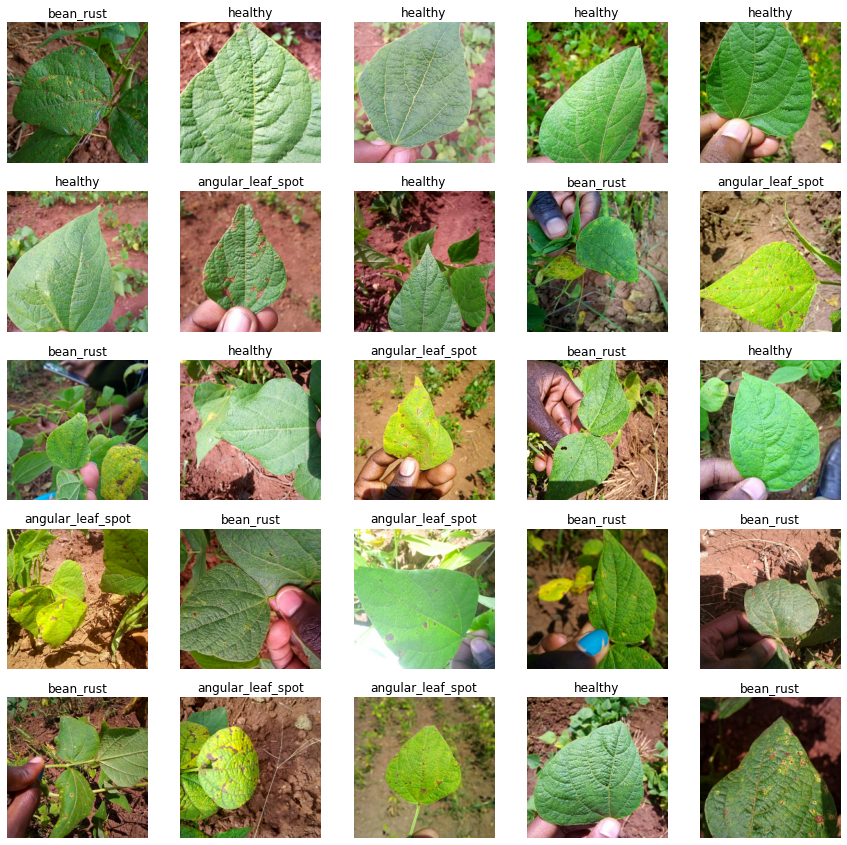

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2.2.3 모델 생성 및 학습

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = Sequential([
        Rescaling(scale=1./255, input_shape=(256, 256, 3)),

        Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(),

        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=3)    # class_names: ['angular_leaf_spot', 'bean_rust', 'healthy']
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(patience = 10)
checkpoint_model = ModelCheckpoint('ModelCheckpoint.h5')

In [17]:
%%time

history = model.fit(train_ds, 
                    validation_data=validation_ds, 
                    epochs=100, 
                    callbacks=[early_stopping, checkpoint_model])

Epoch 1/100
33/33 [==============================] - 45s 1s/step - loss: 1.3375 - accuracy: 0.4391 - val_loss: 0.8409 - val_accuracy: 0.6015
Epoch 2/100
33/33 [==============================] - 45s 1s/step - loss: 0.7694 - accuracy: 0.6625 - val_loss: 0.6558 - val_accuracy: 0.7444
Epoch 3/100
33/33 [==============================] - 45s 1s/step - loss: 0.6230 - accuracy: 0.7447 - val_loss: 0.5805 - val_accuracy: 0.7744
Epoch 4/100
33/33 [==============================] - 45s 1s/step - loss: 0.5467 - accuracy: 0.7747 - val_loss: 0.5404 - val_accuracy: 0.7820
Epoch 5/100
33/33 [==============================] - 45s 1s/step - loss: 0.4491 - accuracy: 0.8337 - val_loss: 0.5401 - val_accuracy: 0.7444
Epoch 6/100
33/33 [==============================] - 44s 1s/step - loss: 0.3813 - accuracy: 0.8520 - val_loss: 0.5150 - val_accuracy: 0.7744
Epoch 7/100
33/33 [==============================] - 44s 1s/step - loss: 0.2862 - accuracy: 0.9004 - val_loss: 0.5266 - val_accuracy: 0.7970
Epoch 8/100
3

In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

# model history
epoch = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Scatter
fig.add_trace(go.Scatter(x=epoch, y=loss, name="loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=val_loss, name="val_loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=accuracy, name="accuracy"),secondary_y=True,)
fig.add_trace(go.Scatter(x=epoch, y=val_accuracy, name="val_accuracy"),secondary_y=True,)

# Templates configuration, Default template: 'plotly'
# Available templates: ['ggplot2', 'seaborn', 'simple_white', 'plotly','plotly_white', 'plotly_dark', 'presentation', 'xgridoff','ygridoff', 'gridon', 'none']
fig.update_layout(title_text="<b>Loss/Accuracy of Model</b>", template='plotly')

fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="Loss", secondary_y=False)
fig.update_yaxes(title_text="Accuracy", secondary_y=True)

fig.show()

## 2.2.4 이미지 확장을 이용하여 과적합 예방

In [20]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

Data_Augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(256, 256, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
) 

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = Sequential([
    Data_Augmentation,
    Rescaling(1./255),

    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(3) # class_names: ['angular_leaf_spot', 'bean_rust', 'healthy']
])

model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [22]:
%%time

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, 
                    validation_data=validation_ds, 
                    epochs=100, 
                    callbacks=[early_stopping, checkpoint_model])

Epoch 1/100


33/33 [==============================] - 54s 2s/step - loss: 1.1059 - accuracy: 0.4729 - val_loss: 0.8628 - val_accuracy: 0.6241
Epoch 2/100
33/33 [==============================] - 51s 2s/step - loss: 0.8121 - accuracy: 0.6257 - val_loss: 0.7042 - val_accuracy: 0.6767
Epoch 3/100
33/33 [==============================] - 51s 2s/step - loss: 0.6922 - accuracy: 0.6983 - val_loss: 0.6113 - val_accuracy: 0.7293
Epoch 4/100
33/33 [==============================] - 51s 2s/step - loss: 0.6704 - accuracy: 0.7031 - val_loss: 0.5515 - val_accuracy: 0.7970
Epoch 5/100
33/33 [==============================] - 51s 2s/step - loss: 0.5987 - accuracy: 0.7505 - val_loss: 0.5158 - val_accuracy: 0.7970
Epoch 6/100
33/33 [==============================] - 50s 2s/step - loss: 0.6436 - accuracy: 0.7166 - val_loss: 0.8742 - val_accuracy: 0.5940
Epoch 7/100
33/33 [==============================] - 51s 2s/step - loss: 0.6172 - accuracy: 0.7302 - val_loss: 0.6135 - val_accuracy: 0.7218
Epoch 8/100
33/33 [======

In [23]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

# model history
epoch = history.epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Scatter
fig.add_trace(go.Scatter(x=epoch, y=loss, name="loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=val_loss, name="val_loss"),secondary_y=False,)
fig.add_trace(go.Scatter(x=epoch, y=accuracy, name="accuracy"),secondary_y=True,)
fig.add_trace(go.Scatter(x=epoch, y=val_accuracy, name="val_accuracy"),secondary_y=True,)

# Templates configuration, Default template: 'plotly'
# Available templates: ['ggplot2', 'seaborn', 'simple_white', 'plotly','plotly_white', 'plotly_dark', 'presentation', 'xgridoff','ygridoff', 'gridon', 'none']
fig.update_layout(title_text="<b>Loss/Accuracy of Model</b>", template='plotly')

fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="Loss", secondary_y=False)
fig.update_yaxes(title_text="Accuracy", secondary_y=True)

fig.show()
